In [103]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import mplcursors




DeSeqOutputAllConds = 'DeSeqOutputAllConds.tsv'
si2_si4_RNA_seq = 'si2-si4_RNA-seq-pipeline-output-normalized.tsv'
le = LabelEncoder()
oh_enc = OneHotEncoder(handle_unknown='ignore')
plsr = PLSRegression(n_components=2)


def getTSVFile(filepath):
    data = pd.read_csv (filepath, sep = '\t')
    return data

#not used or necessary
def integerEncode(dataframe, columnNametoEncode, newEncodedColumnName):
    dataframe[columnNametoEncode] = le.fit_transform(df[newEncodedColumnName])
    return dataframe
  
#https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python  
def oneHotEncode(df, columnsToEncode):
    
    for column in columnsToEncode:
        # Get one hot encoding of column and drop 'column'
        one_hot = pd.get_dummies(df[column])
        # Drop column  as it is now encoded
        df = df.drop(column, axis = 1)
        # Join the encoded df
        df = df.join(one_hot)
    
    return df


def zScoreData(df, columnsToZScore):
    for column in columnsToZScore:
        df[column] = zscore(df[column])
        
    return df

def fixBadChromosomeLabeling(df, column='chrom'): 
    replace = list(range(1, 23)) + ['X', 'Y']
    
    for i in replace:
        df[column].replace(str(i), 'chr' + str(i), inplace=True)
        
    return df


In [157]:
df = getTSVFile(si2_si4_RNA_seq)
df = df.loc[df['counts'] > 0]#Filter out rows where count is zero
df = fixBadChromosomeLabeling(df)

#Set up copies to play around with lader
#df_original = df.copy()

#Remove unnecessary columns
#['experiment', 'sampleID', 'counts', 'tpm', 'gene_name', 'chrom'] Leon..KEEP
df = df[['sampleID', 'tpm', 'gene_name']]

#display(df.sampleID.unique())

df = oneHotEncode(df, ['sampleID'])
df = zScoreData(df, ['tpm'])




#Leon if you want to get top n%
# Probably simpler - https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.nlargest.html
# Sort, .head(...) - https://stackoverflow.com/questions/53405458/selecting-the-top-50-percentage-names-from-the-columns-of-a-pandas-dataframe



array(['01-TGFb-low', '02-TGFb-med', '03-RA-low', '04-EtOH-highDensity',
       '05-EtOH-nlDensity', '06-RA-high', '07-EtOH-halfDensity',
       '08-TGFb-and-RA-low', '09-TGFb-and-RA-med', '10-TGFb-high',
       '11-TGFb-and-RA-high', '12-RA-med', '13-TGFb-and-RA-low',
       '14-EtOH-highDensity', '15-EtOH-nlDensity', '16-TGFb-med',
       '19-TGFb-low', '20-EtOH-halfDensity', '21-TGFb-and-RA-high',
       '22-TGFb-high', '23-RA-high', '24-RA-low', '25-EtOH-halfDensity',
       '26-RA-med', '27-EtOH-nlDensity', '28-TGFb-and-RA-med',
       '29-TGFb-and-RA-low', '30-TGFb-med', '31-TGFb-high', '32-RA-high',
       '33-TGFb-low', '34-EtOH-highDensity', '35-TGFb-and-RA-high',
       '36-RA-low', '46-EtOH-nlDensity', '51-RA-med',
       '52-TGFb-and-RA-med'], dtype=object)

In [ ]:
df_test = df_original.copy()
df_test = df_test.loc[df_test['counts'] > 0]


print(len(df_test['gene_name'].unique()))

#Group by gene and therapeutic level, sorting by average tpm value w/ highest tpm first, 
#getting top 20

#print(len(df_test[['gene_name'== 'MT-CO2', 'sampleID' =='35-TGFb-and-RA-high']]))
df_test.query('gene_name=="MT-CO2" & sampleID=="35-TGFb-and-RA-high"')



#Homework: Get top 10 results, for gene_name, sampleID, and both and PLOT IT
df_test.groupby(['gene_name', 'sampleID' ]).mean().sort_values(by=['tpm'], ascending=False)[:20]


#1. One hot encode the genes. When they are numbers they wont disappear using 'groupby'
#2. Groupby by sampleID(treatments)
#3. Remove columns [counts, rpm, rpkm, tx_start, tx_end, TSS_loc]
#4. Transpose the dataframe so the genes are the row
#5. Sort by tpm and get top n results. So you top 20 genes
#6. Transpose it back and now you have top 20 columns




In [192]:
# Retinoic Acid (50, 200 and 400 nM)
# TGF-β (1.25, 5, and 10 ng/mL)


sampleIDs_transform = {
  'RA-high': {'TGFb': 0, 'retinoicAcid': 400, 'EtOH': 0}, 
  'EtOH-nlDensity': {'TGFb': 0, 'retinoicAcid': 0, 'EtOH': 0},
  'RA-med': {'TGFb': 0, 'retinoicAcid': 200, 'EtOH': 0}, 
  'EtOH-halfDensity': {'TGFb': 0, 'retinoicAcid': 0, 'EtOH': 0}, 
  'RA-low': {'TGFb': 0, 'retinoicAcid': 50, 'EtOH': 0},
  'EtOH-highDensity': {'TGFb': 0, 'retinoicAcid': 0, 'EtOH': 0}, 
  'TGFb-and-RA-low': {'TGFb': 1.25, 'retinoicAcid': 50, 'EtOH': 0}, 
  'TGFb-and-RA-high': {'TGFb': 10, 'retinoicAcid': 400, 'EtOH': 0},
  'TGFb-and-RA-med': {'TGFb': 5, 'retinoicAcid': 200, 'EtOH': 0}, 
  'TGFb-high': {'TGFb': 10, 'retinoicAcid': 0, 'EtOH': 0}, 
  'TGFb-low': {'TGFb': 1.25, 'retinoicAcid': 0, 'EtOH': 0}, 
  'TGFb-med': {'TGFb': 5, 'retinoicAcid': 0, 'EtOH': 0}
}

tpm
gene_name sampleID                      
MT-CO2    TGFb-and-RA-high  31757.766300
          EtOH-highDensity  31195.055071
          TGFb-high         31161.369708
          RA-high           29523.226736
          EtOH-halfDensity  29201.088032
          TGFb-low          28801.578003
          TGFb-med          28448.271761
          EtOH-nlDensity    28268.238674
          RA-med            28237.334593
          RA-low            28176.280493
          TGFb-and-RA-med   27122.040836
          TGFb-and-RA-low   27057.092636
MT-ND4    EtOH-highDensity  24602.332575
MT-ATP6   EtOH-highDensity  24241.945762
          RA-high           24043.865016
MT-ND4    EtOH-halfDensity  24040.060775
MT-ATP6   TGFb-and-RA-high  23736.068870
          RA-low            23530.511603
          EtOH-nlDensity    23509.028560
          RA-med            23441.604516
MT-ND4    RA-high           23103.660357
          TGFb-and-RA-high  22856.216602
          TGFb-high         22816.072411
MT-ATP6   TGFb-and-RA-low   22811.748314
MT-ND4    EtOH-nlDensity    22796.771521
MT-ATP6   TGFb-med          22639.634156
          EtOH-halfDensity  22624.392903
          TGFb-high         22558.363671
MT-ND4    RA-low            22494.388776
MT-ATP8   EtOH-highDensity  22461.021794
MT-ATP6   TGFb-low          22408.436076
          TGFb-and-RA-med   22172.186151
MT-CO3    EtOH-highDensity  22103.237764
MT-ND4    RA-med            22079.422986
MT-CO3    EtOH-halfDensity  21843.484399
          RA-med            21769.169282
          RA-high           21701.808047
          TGFb-and-RA-high  21639.923707
          RA-low            21612.226973
MT-ATP8   TGFb-and-RA-high  21440.100433
          EtOH-halfDensity  21220.907273
MT-ND4    TGFb-med          21148.843850
MT-CYB    TGFb-and-RA-high  21049.633680
MT-CO3    EtOH-nlDensity    21034.094711
          TGFb-high         20832.657175
MT-ATP8   RA-med            20817.512222
MT-ND4    TGFb-low          20792.331101
MT-ATP8   TGFb-high         20461.811589
MT-CYB    RA-high           20439.517565
          EtOH-highDensity  20364.086534

,TGFb,retinoicAcid,EtOH
MT-CO2,10,400,0
MT-CO2,0,0,0
MT-CO2,10,0,0
MT-CO2,0,400,0
MT-CO2,0,0,0
MT-CO2,1,0,0
MT-CO2,5,0,0
MT-CO2,0,0,0
MT-CO2,0,200,0
MT-CO2,0,50,0


gene_name  sampleID        
MT-CO2     TGFb-and-RA-high    31757.766300
           EtOH-highDensity    31195.055071
           TGFb-high           31161.369708
           RA-high             29523.226736
           EtOH-halfDensity    29201.088032
           TGFb-low            28801.578003
           TGFb-med            28448.271761
           EtOH-nlDensity      28268.238674
           RA-med              28237.334593
           RA-low              28176.280493
           TGFb-and-RA-med     27122.040836
           TGFb-and-RA-low     27057.092636
MT-ND4     EtOH-highDensity    24602.332575
MT-ATP6    EtOH-highDensity    24241.945762
           RA-high             24043.865016
MT-ND4     EtOH-halfDensity    24040.060775
MT-ATP6    TGFb-and-RA-high    23736.068870
           RA-low              23530.511603
           EtOH-nlDensity      23509.028560
           RA-med              23441.604516
MT-ND4     RA-high             23103.660357
           TGFb-and-RA-high    22856.216602
    

PLSR Variance captured:  0.0009713932769096489


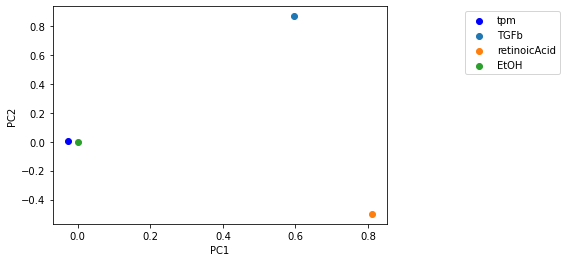

In [244]:
#https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
def combineTreatmentColumns(df, exceptions):
    df.rename(columns=lambda x: x[3:] if x not in exceptions else x, inplace=True)
    return df

def changeTreatmentNameInRows(df, columnName='sampleID', exceptions={}):
    df[columnName] = df[columnName].apply(lambda x: x[3:] if x not in exceptions else x)
    return df
    
    
def printPLSRPlot(x_loadings_, y_loadings_, loadings):
    plt.scatter(y_loadings_[:, 0], y_loadings_[:, 1], color='blue', label='tpm')
    
    for i in range(x_loadings_.shape[0]):
        plt.scatter(x_loadings_[i,0], x_loadings_[i, 1], label=loadings[i])
        
    plt.legend(bbox_to_anchor=(1.53, 1))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
    
def getPLSR_DFs(groupby=['sampleID', 'gene_name'], columns=['sampleID', 'tpm', 'gene_name'], topN=5000):
    df_plsr = df_original.copy()
    df_plsr = df_plsr[columns]

    gb = df_plsr.groupby(groupby).mean().sort_values(by=['tpm'], ascending=False)[:topN]
    #Extract rows and columns of top N results by indices
    rows = set([groupby[0] for groupby in gb.index])
    columns = set([groupby[1] for groupby in gb.index])

    #Create a new dataframe
    new_df = pd.DataFrame(0, index=rows, columns=columns)
    new_df_log = new_df.copy()

    #Iterate
    for (row, col) in gb.index:
        tpv_val = gb.loc[row, col].tpm
        new_df.loc[row, col] = tpv_val
        new_df_log.loc[row, col] = np.log(tpv_val)
        
    return new_df, new_df_log


#new_df, new_df_log = getPCA_DFs()

#Something wrong my PLSR logic

#display(df_original)


def createPLSRMatrix(df, newColumns=['TGFb', 'retinoicAcid', 'EtOH']):
    #Create a new dataframe    
    new_indexes = [gene for (gene, treatment) in df.index]
    new_df = pd.DataFrame(0, index=new_indexes, columns=newColumns)
    
    test = df[:100]
        
    for i in range(len(new_df.index)):
        
        (gene_name, treatment) = df.iloc[i].name
        
        
        new_df.iat[i, 0] = sampleIDs_transform[treatment]['TGFb']
        new_df.iat[i, 1]= sampleIDs_transform[treatment]['retinoicAcid']
        new_df.iat[i, 2]= sampleIDs_transform[treatment]['EtOH']
        
    

    return new_df


df_plsr = df_original.copy()
df_plsr = df_plsr[['sampleID', 'tpm', 'gene_name']]



#df_plsr = oneHotEncode(df_plsr, ['sampleID'])
#df_plsr = combineTreatmentColumns(df_plsr, {'tpm', 'gene_name'})
#display(df_plsr.columns) Shows the fixed column names


#display(df_plsr[df_plsr['sampleID'].str.contains("TGFb-and-RA-low")])

changeTreatmentNameInRows(df_plsr, columnName='sampleID')


#display(df_plsr[df_plsr['sampleID'] == 'RA-high'])


df_plsr = df_plsr.groupby(['gene_name', 'sampleID']).mean().sort_values(by=['tpm'], ascending=False)[:50]
Y = df_plsr['tpm']



better_df = createPLSRMatrix(df_plsr)
display(df_plsr)
display(better_df)
display(Y)

#display(better_df, Y[:20])





loadings = [col for col in df_plsr.columns if col != 'tpm'] #Remove 'tpm' to fit for PLSR
plsr.fit(better_df, Y)
print('PLSR Variance captured: ', plsr.score(better_df, Y))
printPLSRPlot(plsr.x_loadings_, plsr.y_loadings_, better_df.columns)



,,tpm
sampleID,gene_name,
35-TGFb-and-RA-high,MT-CO2,40095.437187
31-TGFb-high,MT-CO2,37089.321282
14-EtOH-highDensity,MT-CO2,34573.327005
20-EtOH-halfDensity,MT-CO2,30770.942552
36-RA-low,MT-CO2,30730.360023
...,...,...
01-TGFb-low,ACTB,5924.099692
30-TGFb-med,KRT8,5919.391663
29-TGFb-and-RA-low,ACTB,5862.717586



    Variance for PCs = [0.78440204 0.21156343 0.0026108 ] 
    Sum of variances = 0.999  
    pca.shape = (3, 15) where rows=loadings=15, columns=PCs=3


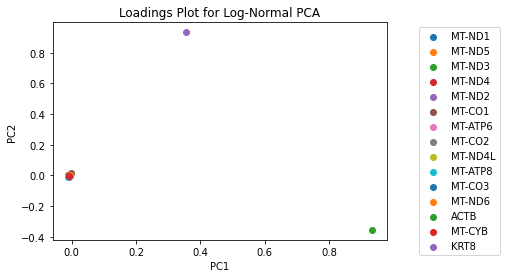


    Variance for PCs = [0.60421674 0.17176473 0.09608637] 
    Sum of variances = 0.872  
    pca.shape = (3, 15) where rows=loadings=15, columns=PCs=3


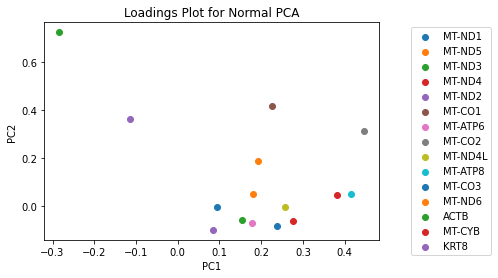

In [113]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

#Guys if you increase the number of PCs you get a lot more variance


def printPCA_2D(new_df, title):
    pca.fit(new_df)

    print('''
    Variance for PCs = %s 
    Sum of variances = %.03f  
    pca.shape = %s where rows=loadings=%d, columns=PCs=%d''' 
          % (pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_), 
             pca.components_.shape, pca.components_.shape[1], pca.components_.shape[0]))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)

    for i in range(pca.components_.shape[1]):
        plt.scatter(pca.components_[0, i], pca.components_[1, i], label=new_df.columns[i])

    mplcursors.cursor(hover=True)

    plt.legend(bbox_to_anchor=(1.35, 1)) 
    plt.show()

    
def printPCA_3D(new_df, title):
    pca.fit(new_df)

    print('''
    Variance for PCs = %s 
    Sum of variances = %.03f  
    pca.shape = %s where rows=loadings=%d, columns=PCs=%d''' 
          % (pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_), 
             pca.components_.shape, pca.components_.shape[1], pca.components_.shape[0]))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)

    for i in range(pca.components_.shape[1]):
        ax.scatter(xs=pca.components_[0, i], ys=pca.components_[1, i], 
                       zs=pca.components_[2, i], label=new_df.columns[i])


    plt.legend(bbox_to_anchor=(1.6, 1)) 
    plt.show()


def getPCA_DFs(groupby=['sampleID', 'gene_name'], keepColumns=['sampleID', 'tpm', 'gene_name'], topN=5000):
    df_pca = df_original.copy()
    df_pca = df_pca[keepColumns]

    #Group data by two columns, which will later be a regular row and column
    gb = df_pca.groupby(groupby).mean().sort_values(by=['tpm'], ascending=False)[:topN]
    
    
    display(gb)
    #Extract rows and columns of top N results by indices
    rows = set([groupby[0] for groupby in gb.index])
    columns = set([groupby[1] for groupby in gb.index])

    #Create a new dataframe
    new_df = pd.DataFrame(0, index=rows, columns=columns)
    new_df_log = new_df.copy()

    #Iterate
    for (row, col) in gb.index:
        tpv_val = gb.loc[row, col].tpm
        new_df.loc[row, col] = tpv_val
        new_df_log.loc[row, col] = np.log(tpv_val)
        
    return new_df, new_df_log

#From Meyer treatments as rows, genes as columns


groupby=['sampleID', 'gene_name'] #Should only be two things! groupby[0] = row, groupby[1] = column
new_df, new_df_log = getPCA_DFs(groupby=groupby, topN=500)

#display(new_df)

printPCA_2D(new_df_log, title='Loadings Plot for Log-Normal PCA' )
printPCA_2D(new_df, title='Loadings Plot for Normal PCA' )

